In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
from torch import nn, optim

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

C:\Users\14388\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

# Load Data

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.1)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.1)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.1):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.1):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
    
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [3]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20):
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    val_dataset = ArgoverseDataset(city = city, split = 'val')

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [4]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 64)
len(val_dataset)

38737

In [5]:
len(train_dataset)

4304

# Model

In [6]:
class LSTM(nn. Module):
    def __init__(self, batch_size = 64, hidden_size = 128, num_layers = 1):
        super().__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = 2, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True)
        self.FC = nn.Linear(self.hidden_size, 2)
        

    def forward(self, x, hidden):
        
        x = x.float()
        out, hidden = self.lstm(x, hidden)
        
        out = self.FC(out)
        
        return out, hidden
    
    def init_hidden(self,batch_size):
        
        weights = next(self.parameters()).data
        
        hidden = (weights.new(self.num_layers, batch_size, self.hidden_size).zero_().float(), # (num_layers, batch_size)
                  weights.new(self.num_layers, batch_size, self.hidden_size).zero_().float())
        
        return hidden

In [8]:
def city_min_max(city):
    _, _, train_loader, val_loader = get_data_loader(city = city, batch_size = len(train_dataset))
    diagonal = maxX = minX = maxY = minY = 0
    for i_batch, sample_batch in enumerate(train_loader):
        sample_batch = torch.concat(sample_batch, axis = 1)
        maxX, minX = sample_batch[:,:,0].max(), sample_batch[:,:,0].min()
        maxY, minY = sample_batch[:,:,1].max(), sample_batch[:,:,1].min()
        diagonal = torch.sqrt((maxX-minX)*(maxX-minX) + (maxY-minY)*(maxY-minY))
    return [maxX, minX, maxY, minY, diagonal]

def city_min_max_dict():
    res = {}
    for city in cities:
        res[city] = city_min_max(city)
    return res

In [9]:
def normalize(inp, maximum, minimum, how = 'normalize'):
    maxX, minX = maximum[:,0], minimum[:,0]
    maxY, minY = maximum[:,0], minimum[:,0]
    diagonal = torch.sqrt((maxX-minX)*(maxX-minX) + (maxY-minY)*(maxY-minY))
    if how == 'normalize':
        res = []
        for batch, m, d in zip(inp, minimum, diagonal):
            res.append(torch.sub(batch, m)/d)
        return torch.stack(res).float()
    if how == 'reverse':
        res = []
        for batch, m, d in zip(inp, minimum, diagonal):
            res.append(batch*d + m)
        return torch.stack(res).float()

In [10]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 10)
for i_batch, sample_batch in enumerate(train_loader):
    sample_batch = torch.concat(sample_batch, axis = 1)
        for i in range(2):
            inp = sample_batch[:,i*50:(i+1)*50,:]
            maximum = inp.max(axis = 1).values+1
            minimum = inp.min(axis = 1).values-1
            # normalization
            normalize(inp, maximum, minimum, how = 'normalize')
            

IndentationError: unexpected indent (38490250.py, line 4)

In [392]:
lstm = LSTM()
opt = optim.Adam(lstm.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_loss = 0
_, _, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = len(train_dataset))
for i_batch, sample_batch in enumerate(train_loader):
    sample_batch = torch.concat(sample_batch, axis = 1)
    maximum = sample_batch.max(axis = 1).values+20
    minimum = sample_batch.min(axis = 1).values-20
    maxX, minX = maximum[:,0], minimum[:,0]
    maxY, minY = maximum[:,0], minimum[:,0]
    print(maximum.shape)
    diagonal = torch.sqrt((maxX-minX)*(maxX-minX) + (maxY-minY)*(maxY-minY))
    print(diagonal.shape)
    res = []
    for batch, m, d in zip(sample_batch, minimum, diagonal):
        res.append(torch.sub(batch, m)/d)
    print(torch.stack(res).shape)
    print(maximum)
    print(minimum)
    print(sample_batch)#[:,1].max())
    break

torch.Size([4304, 2])
torch.Size([4304])
torch.Size([4304, 110, 2])
tensor([[ -351.9597,   889.7750],
        [ -188.8811,   502.1945],
        [ 2123.6430, -1585.9456],
        ...,
        [ -115.8651, -1262.5304],
        [  -78.7036,  -612.1985],
        [ -230.1506,  1094.9175]], dtype=torch.float64)
tensor([[ -392.2322,   847.1345],
        [ -259.6579,   360.4923],
        [ 2059.7451, -1693.2593],
        ...,
        [ -167.2549, -1351.9212],
        [ -190.8524,  -674.5488],
        [ -280.2172,  1003.6119]], dtype=torch.float64)
tensor([[[ -371.9725,   869.6596],
         [ -371.9723,   869.6593],
         [ -371.9720,   869.6592],
         ...,
         [ -372.1832,   867.6788],
         [ -372.2095,   867.3911],
         [ -372.2322,   867.1345]],

        [[ -208.8811,   482.1945],
         [ -209.0317,   481.6050],
         [ -209.2325,   480.8890],
         ...,
         [ -239.5730,   380.7581],
         [ -239.6217,   380.6076],
         [ -239.6579,   380.4923]],

  

In [11]:
def train_epochs(model, train_dataset, train_loader, loss_func, opt, batch_size, epochs = 10):
    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            sample_batch = torch.concat(sample_batch, axis = 1)
            for i in range(2):
                inp = sample_batch[:,i*50:(i+1)*50,:]
                maximum = inp.max(axis = 1).values+1
                minimum = inp.min(axis = 1).values-1
                # normalization
                inp = normalize(inp, maximum, minimum, how = 'normalize')
                
                out = sample_batch[:,i*50+1:(i+1)*50+1,:]
                out = out.float()
                
                # init hidden states
                h = model.init_hidden(inp.shape[0])
                
                # prediction
                preds, _ = model(inp, h)
                preds = normalize(preds, maximum, minimum, how = 'reverse')
                loss = loss_func(preds, out)

                opt.zero_grad()
                loss.backward()
                opt.step()

                total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / (len(train_dataset)*2))
    return train_losses

In [12]:
def val_loss(model, val_loader, loss_func, opt):
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        out = out.float()
        preds = model(inp)
        loss = loss_func(preds, out) # MSE
        #loss = torch.sqrt(loss_func(preds, out)) # RMSE

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [13]:
def train_city(city, batch_size, epochs, model):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model_encdoc = model
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_dataset, train_loader, loss_func, opt, batch_size, epochs = epochs)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

# Training

In [14]:
lstm = LSTM()
opt = optim.Adam(lstm.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
model_austin, train_losses = train_city('austin', batch_size = 128, epochs = 10, model = lstm)

epoch 0 trian loss: 1.1438868258522346
epoch 1 trian loss: 0.20265075298490134
epoch 2 trian loss: 0.12056106716726793
epoch 3 trian loss: 0.08615755070984142
epoch 4 trian loss: 0.06482210422980297
epoch 5 trian loss: 0.048769403899912495
epoch 6 trian loss: 0.035096621729405836
epoch 7 trian loss: 0.026958336755910327
epoch 8 trian loss: 0.021673208968125312
epoch 9 trian loss: 0.0174283448011237


In [511]:
# miami
model = LSTM()
model_miami, train_losses = train_city('miami', batch_size = 128, epochs = 10, model = model)

epoch 0 trian loss: 0.6996646434426178
epoch 1 trian loss: 0.10192262489377087
epoch 2 trian loss: 0.05895808383535359
epoch 3 trian loss: 0.039356976606680326
epoch 4 trian loss: 0.027435437272739862
epoch 5 trian loss: 0.019393314343719038
epoch 6 trian loss: 0.013297961922568956
epoch 7 trian loss: 0.009181177949784063
epoch 8 trian loss: 0.007187541646010136
epoch 9 trian loss: 0.004679342127201645


In [512]:
# pittsburgh
model = LSTM()
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 128, epochs = 10, model = model)

epoch 0 trian loss: 0.8785172605567916
epoch 1 trian loss: 0.15234190443779658
epoch 2 trian loss: 0.08934505988506204
epoch 3 trian loss: 0.06200308441605845
epoch 4 trian loss: 0.04657862538648928
epoch 5 trian loss: 0.035361664588308604
epoch 6 trian loss: 0.025396661269087063
epoch 7 trian loss: 0.018552193991398395
epoch 8 trian loss: 0.014353059064109198
epoch 9 trian loss: 0.011146067723385446


In [513]:
# dearborn
model = LSTM()
model_dearborn, train_losses = train_city('dearborn', batch_size = 128, epochs = 10, model = model)

epoch 0 trian loss: 2.6705615339177804
epoch 1 trian loss: 0.8198084842934534
epoch 2 trian loss: 0.40010392890050583
epoch 3 trian loss: 0.27516686282777825
epoch 4 trian loss: 0.21209165100571764
epoch 5 trian loss: 0.169051072876276
epoch 6 trian loss: 0.13831314451852394
epoch 7 trian loss: 0.11532150675601288
epoch 8 trian loss: 0.09674786858546958
epoch 9 trian loss: 0.08019321830372096


In [514]:
# washington_dc
model = LSTM()
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 128, epochs = 10, model = model)

epoch 0 trian loss: 1.7021853595902592
epoch 1 trian loss: 0.4399799744843881
epoch 2 trian loss: 0.20162403778040602
epoch 3 trian loss: 0.13777359011753085
epoch 4 trian loss: 0.10513982591280756
epoch 5 trian loss: 0.08358460539704436
epoch 6 trian loss: 0.06893526424061168
epoch 7 trian loss: 0.05818317116186798
epoch 8 trian loss: 0.049258689919273894
epoch 9 trian loss: 0.04050426702677231


In [515]:
# palo_alto
model = LSTM()
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 128, epochs = 10, model = model)

epoch 0 trian loss: 3.083900693459149
epoch 1 trian loss: 1.183693142112242
epoch 2 trian loss: 0.6522291436406152
epoch 3 trian loss: 0.41429494996186195
epoch 4 trian loss: 0.3063684842107294
epoch 5 trian loss: 0.2540908683032369
epoch 6 trian loss: 0.22171622141885003
epoch 7 trian loss: 0.19749431832817022
epoch 8 trian loss: 0.1772657184425844
epoch 9 trian loss: 0.16015046551587483


# Make Predictions

In [15]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

NameError: name 'model_miami' is not defined

In [16]:
def predict(model, inp):
    # init hidden states
    h = model.init_hidden(inp.shape[0])
    preds = []
    p_t = inp
    maximum = p_t.max(axis = 1).values+1
    minimum = p_t.min(axis = 1).values-1
    p_t = normalize(p_t, maximum, minimum, how = 'normalize')
    for i in range(60):
        p_t, h = model(inp, h)
        preds.append(normalize(p_t[:,49:50,:], maximum, minimum, how = 'reverse'))
    preds = torch.concat(preds, axis = 1)
    return preds

In [17]:
def predict_test(city, model):
    test_dataset = get_city_trajectories(city = city, split = 'test')[0]
    test_dataset = torch.from_numpy(test_dataset)
    pred = predict(model, test_dataset).reshape(-1, 120)
    return pd.DataFrame(pred.detach().numpy())

In [ ]:
test_dataset = get_city_trajectories(city = 'austin', split = 'test')[0]
test_dataset = torch.from_numpy(test_dataset)#[:100,:,:]
print(test_dataset.shape)
predict(model_austin, test_dataset)

torch.Size([6325, 50, 2])


In [524]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [525]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns
    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    
    return out        

In [526]:
test_output = predict_all(cities, models)

KeyboardInterrupt: 

In [ ]:
test_output

# Visualization

In [493]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'miami', batch_size = 10)

tensor([[[0.3352, 1.4284],
         [0.3358, 1.4126],
         [0.3365, 1.3945],
         [0.3372, 1.3742],
         [0.3380, 1.3510],
         [0.3389, 1.3268],
         [0.3397, 1.3018],
         [0.3404, 1.2758],
         [0.3412, 1.2509],
         [0.3419, 1.2274],
         [0.3426, 1.2059],
         [0.3432, 1.1846],
         [0.3438, 1.1632],
         [0.3443, 1.1417],
         [0.3449, 1.1195],
         [0.3455, 1.0973],
         [0.3461, 1.0749],
         [0.3468, 1.0521],
         [0.3476, 1.0289],
         [0.3484, 1.0051],
         [0.3493, 0.9821],
         [0.3502, 0.9589],
         [0.3512, 0.9354],
         [0.3521, 0.9130],
         [0.3531, 0.8906],
         [0.3540, 0.8683],
         [0.3550, 0.8471],
         [0.3559, 0.8259],
         [0.3568, 0.8045],
         [0.3575, 0.7832],
         [0.3582, 0.7618],
         [0.3589, 0.7397],
         [0.3594, 0.7175],
         [0.3599, 0.6958],
         [0.3602, 0.6754],
         [0.3606, 0.6555],
         [0.3610, 0.6357],
 

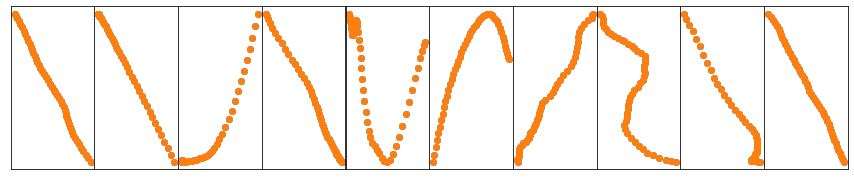

In [504]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    maximum = inp.max(axis = 1).values+10
    minimum = inp.min(axis = 1).values-10
    inp = normalize(inp, maximum, minimum, how = 'normalize')
    print(inp)

    pred = predict(model_austin, inp).detach()
    show_sample_batch([inp, inp])
    #show_sample_batch([inp, pred])
    print(pred.shape)
    break